🔧 Function Purpose
Cleans and enriches the FHVHV trip dataset using Dask & Pandas.

✅ Main Steps Performed
🧾 Load & Merge

Loads raw FHVHV trip data (Parquet) and zone lookup (CSV).

Merges pickup/dropoff locations with zone names (borough, zone, service zone).

📅 Datetime Processing

Imputes missing on_scene_datetime using median dispatch delay.

Calculates and removes rows with mismatched trip time (>5 min).

🧮 Fare & Pay Fixes

Identifies and imputes:

Negative base_passenger_fare

Negative driver_pay

Removes rows with trip_miles <= 0.05 and fare > 0.

🧷 Feature Engineering

Maps hvfhs_license_num to service type (Uber, Lyft, etc.).

Adds:

average_speed

fare_per_mile

total_fare_components

pickup_hour, dropoff_hour

trip_category (Shared/Solo)

is_congested flag (speed < 5 mph)

trip_distance_class (short/medium/long)

🧼 Cleanup & Export

Drops unneeded columns.

Optionally exports cleaned dataset to CSV or Parquet.

In [12]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

def process_fhvhv_data(fhvhv_path, lookup_path, output_path=None, output_format="csv", verbose=True, keep_diagnostics=False):
    # Load data using Dask
    if verbose: print("📥 Loading data...")
    fhvhv = dd.read_parquet(fhvhv_path)
    lookup = dd.read_csv(lookup_path)

    # Merge zone info
    def merge_lookup_dask(df, pickup_col, dropoff_col, lookup):
        df = df.merge(lookup, left_on=pickup_col, right_on="LocationID", how="left").rename(
            columns={"Borough": "PU_Borough", "Zone": "PU_Zone", "service_zone": "PU_ServiceZone"}).drop(columns=["LocationID"])
        df = df.merge(lookup, left_on=dropoff_col, right_on="LocationID", how="left").rename(
            columns={"Borough": "DO_Borough", "Zone": "DO_Zone", "service_zone": "DO_ServiceZone"}).drop(columns=["LocationID"])
        return df

    fhvhv = merge_lookup_dask(fhvhv, "PULocationID", "DOLocationID", lookup)
    fhvhv = fhvhv.compute()

    # Impute missing on_scene_datetime
    def impute_on_scene_datetime_inplace(df):
        for col in ['request_datetime', 'on_scene_datetime', 'pickup_datetime']:
            df[col] = pd.to_datetime(df[col], errors='coerce')
        valid_mask = df['on_scene_datetime'].notna() & df['request_datetime'].notna()
        df['arrival_delta'] = (df['on_scene_datetime'] - df['request_datetime']).dt.total_seconds()
        df_valid = df[valid_mask & (df['arrival_delta'] > 0) & (df['arrival_delta'] < 1800)]
        avg_arrival_seconds = df_valid['arrival_delta'].median()
        if verbose: print(f"📏 Median dispatch-to-arrival time: {avg_arrival_seconds:.1f}s")
        missing_mask = df['on_scene_datetime'].isna() & df['request_datetime'].notna()
        df.loc[missing_mask, 'on_scene_datetime'] = df.loc[missing_mask, 'request_datetime'] + pd.to_timedelta(avg_arrival_seconds, unit='s')
        df.drop(columns='arrival_delta', inplace=True)
        if verbose: print(f"✅ Imputed rows: {missing_mask.sum()} / {len(df):,}")

    impute_on_scene_datetime_inplace(fhvhv)

    fhvhv.drop(columns='originating_base_num', inplace=True)

    # Safe mode-based imputation
    for col, loc_col in [('PU_Borough', 'PULocationID'), ('DO_Borough', 'DOLocationID'),
                         ('PU_Zone', 'PULocationID'), ('DO_Zone', 'DOLocationID'),
                         ('PU_ServiceZone', 'PULocationID'), ('DO_ServiceZone', 'DOLocationID')]:
        if col in fhvhv.columns:
            mask_valid = ~fhvhv[loc_col].isin([264, 265])
            fhvhv.loc[mask_valid, col] = fhvhv[mask_valid].groupby(loc_col)[col].transform(
                lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
            )

    fhvhv.loc[fhvhv['PULocationID'] == 264, ['PU_Borough', 'PU_Zone', 'PU_ServiceZone']] = 'Unknown'
    fhvhv.loc[fhvhv['DOLocationID'] == 264, ['DO_Borough', 'DO_Zone', 'DO_ServiceZone']] = 'Unknown'
    fhvhv.loc[fhvhv['PULocationID'] == 265, ['PU_Borough', 'PU_Zone', 'PU_ServiceZone']] = 'Outside NYC'
    fhvhv.loc[fhvhv['DOLocationID'] == 265, ['DO_Borough', 'DO_Zone', 'DO_ServiceZone']] = 'Outside NYC'

    # Drop rows with mismatched trip_time
    fhvhv['calculated_trip_time'] = (fhvhv['dropoff_datetime'] - fhvhv['pickup_datetime']).dt.total_seconds()
    fhvhv['trip_time_diff'] = fhvhv['trip_time'] - fhvhv['calculated_trip_time']
    fhvhv = fhvhv[fhvhv['trip_time_diff'].abs() <= 300].copy()
    fhvhv.drop(columns=['calculated_trip_time', 'trip_time_diff'], inplace=True)
    if verbose: print(f"✅ Cleaned mismatched trip_time rows. Remaining: {len(fhvhv):,}")

    # Fix negative base_passenger_fare
    fare_cols = ['tolls', 'sales_tax', 'bcf', 'congestion_surcharge', 'airport_fee']
    fhvhv['fare_components_sum'] = fhvhv[fare_cols].sum(axis=1)
    mask = fhvhv['base_passenger_fare'] < 0
    fhvhv.loc[mask, 'imputed_base_fare'] = fhvhv.loc[mask, 'fare_components_sum']
    fhvhv.loc[mask, 'base_passenger_fare'] = fhvhv.loc[mask, 'imputed_base_fare']
    fhvhv.drop(columns='imputed_base_fare', inplace=True)
    if verbose: print(f"✅ Remaining negative base fares: {(fhvhv['base_passenger_fare'] < 0).sum()}")

    # Fix negative driver_pay
    mask_neg_driver = fhvhv['driver_pay'] < 0
    fhvhv.loc[mask_neg_driver, 'imputed_driver_pay'] = (
        fhvhv.loc[mask_neg_driver, 'base_passenger_fare'] + fhvhv.loc[mask_neg_driver, 'tips']
    )
    fhvhv.loc[mask_neg_driver, 'driver_pay'] = fhvhv.loc[mask_neg_driver, 'imputed_driver_pay']
    fhvhv.drop(columns='imputed_driver_pay', inplace=True)
    if verbose: print(f"✅ Remaining negative driver_pay values: {(fhvhv['driver_pay'] < 0).sum()}")

    # Drop tiny-distance but nonzero fare rows
    fhvhv = fhvhv[~((fhvhv['trip_miles'] <= 0.05) & (fhvhv['base_passenger_fare'] > 0))]

    # Add fhvhv_type
    license_mapping = {
        "HV0002": "Juno",
        "HV0003": "Uber",
        "HV0004": "Via",
        "HV0005": "Lyft"
    }
    fhvhv['fhvhv_type'] = fhvhv['hvfhs_license_num'].map(license_mapping)

    # Average speed
    fhvhv['average_speed'] = fhvhv.apply(
        lambda row: row['trip_miles'] / (row['trip_time'] / 3600) if row['trip_time'] > 0 else 0, axis=1
    )

    # Fare per mile
    fhvhv['fare_per_mile'] = fhvhv['base_passenger_fare'] / fhvhv['trip_miles']
    fhvhv['fare_per_mile'].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Total fare
    total_fare_cols = ['base_passenger_fare'] + fare_cols
    fhvhv['total_fare_components'] = fhvhv[total_fare_cols].sum(axis=1)

    # Hour extraction
    fhvhv['pickup_hour'] = pd.to_datetime(fhvhv['pickup_datetime'], errors='coerce').dt.hour
    fhvhv['dropoff_hour'] = pd.to_datetime(fhvhv['dropoff_datetime'], errors='coerce').dt.hour

    # Trip category
    fhvhv['trip_category'] = fhvhv['shared_match_flag'].map(lambda x: 'Shared' if x == 'Y' else 'Solo')

    # Congestion flag
    fhvhv['is_congested'] = fhvhv['average_speed'] < 5

    # Trip distance class
    fhvhv['trip_distance_class'] = pd.cut(
        fhvhv['trip_miles'], bins=[0, 2, 7, np.inf], labels=['short', 'medium', 'long'], right=True, include_lowest=True
    )

    # Drop unneeded if not keeping diagnostics
    drop_cols = ['pickup_date']
    if not keep_diagnostics:
        drop_cols += ['fare_diff', 'fare_components_sum']
    fhvhv.drop(columns=[col for col in drop_cols if col in fhvhv.columns], inplace=True)

    # Export
    if output_path:
        if verbose: print(f"💾 Exporting to {output_path}...")
        if output_format == "csv":
            fhvhv.to_csv(output_path, index=False)
        elif output_format == "parquet":
            fhvhv.to_parquet(output_path, index=False)
        else:
            print("⚠️ Unknown export format. Skipping export.")

    if verbose: print("✅ Processing complete.")

    return fhvhv


    fhvhv_path="fhvhv_merged24_daily_sample.parquet",


In [8]:
import pandas as pd
import numpy as np
import dask.dataframe as dd

In [3]:
fhvhv=pd.read_parquet('Cleaned_FHVHV.parquet')

In [4]:
fhvhv

,hvfhs_license_num,dispatching_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,...,DO_ServiceZone,fhvhv_type,average_speed,fare_per_mile,total_fare_components,pickup_hour,dropoff_hour,trip_category,is_congested,trip_distance_class
0,HV0003,B03404,2023-12-31 23:59:26,2024-01-01 00:00:13,2024-01-01 00:00:48,2024-01-01 00:30:38,75,7,7.82,1790,...,Boro Zone,Uber,15.727374,4.375959,40.95,0,0,Solo,False,long
1,HV0003,B03404,2023-12-31 23:58:59,2024-01-01 00:04:04,2024-01-01 00:04:22,2024-01-01 00:39:07,132,181,27.16,2085,...,Boro Zone,Uber,46.894964,1.984536,62.96,0,0,Solo,False,long
2,HV0003,B03404,2023-12-31 23:58:14,2023-12-31 23:59:49,2024-01-01 00:01:30,2024-01-01 00:05:21,215,205,0.77,231,...,Boro Zone,Uber,12.000000,11.597403,9.97,0,0,Solo,False,short
3,HV0003,B03404,2023-12-31 23:57:50,2024-01-01 00:01:09,2024-01-01 00:01:38,2024-01-01 00:23:36,75,81,12.94,1318,...,Boro Zone,Uber,35.344461,2.142195,30.94,0,0,Solo,False,long
4,HV0003,B03404,2023-12-31 23:59:38,2024-01-01 00:05:10,2024-01-01 00:05:20,2024-01-01 00:12:47,132,10,2.58,447,...,Boro Zone,Uber,20.778523,5.930233,19.87,0,0,Solo,False,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11970145,HV0003,B03404,2024-12-31 23:02:02,2024-12-31 23:05:10,2024-12-31 23:05:23,2024-12-31 23:22:05,22,149,3.36,1002,...,Boro Zone,Uber,12.071856,5.845238,21.93,23,23,Solo,False,medium
11970146,HV0003,B03404,2024-12-31 23:33:45,2024-12-31 23:36:59,2024-12-31 23:38:23,2025-01-01 00:08:09,117,139,13.98,1786,...,Boro Zone,Uber,28.179171,3.528612,55.05,23,0,Solo,False,long
11970147,HV0003,B03404,2024-12-31 22:32:33,2024-12-31 22:42:47,2024-12-31 22:43:49,2024-12-31 22:48:55,258,197,0.79,306,...,Boro Zone,Uber,9.294118,16.126582,14.22,22,22,Shared,False,short
11970148,HV0003,B03404,2024-12-31 22:21:28,2024-12-31 22:24:48,2024-12-31 22:26:48,2024-12-31 23:40:56,185,37,18.45,4448,...,Boro Zone,Uber,14.932554,4.248780,95.32,22,23,Solo,False,long


In [5]:
fhvhv.describe

<bound method NDFrame.describe of          hvfhs_license_num dispatching_base_num     request_datetime  \
0                   HV0003               B03404  2023-12-31 23:59:26   
1                   HV0003               B03404  2023-12-31 23:58:59   
2                   HV0003               B03404  2023-12-31 23:58:14   
3                   HV0003               B03404  2023-12-31 23:57:50   
4                   HV0003               B03404  2023-12-31 23:59:38   
...                    ...                  ...                  ...   
11970145            HV0003               B03404  2024-12-31 23:02:02   
11970146            HV0003               B03404  2024-12-31 23:33:45   
11970147            HV0003               B03404  2024-12-31 22:32:33   
11970148            HV0003               B03404  2024-12-31 22:21:28   
11970149            HV0003               B03404  2024-12-31 22:15:38   

            on_scene_datetime      pickup_datetime     dropoff_datetime  \
0         2024-01-01 00:00

In [2]:
import pandas as pd

In [3]:
df = pd.read_parquet("Cleaned_FHVHV.parquet")

In [4]:
datetime_cols = ["pickup_datetime", "dropoff_datetime", "request_datetime", "on_scene_datetime"]

for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')


In [5]:
print(df[datetime_cols].dtypes)
print(df[datetime_cols].isnull().sum())  # Check how many failed to parse


pickup_datetime      datetime64[ns]
dropoff_datetime     datetime64[ns]
request_datetime     datetime64[ns]
on_scene_datetime    datetime64[ns]
dtype: object
pickup_datetime         0
dropoff_datetime        0
request_datetime     5262
on_scene_datetime    5262
dtype: int64


In [6]:
df = df.dropna(subset=['request_datetime', 'on_scene_datetime'])


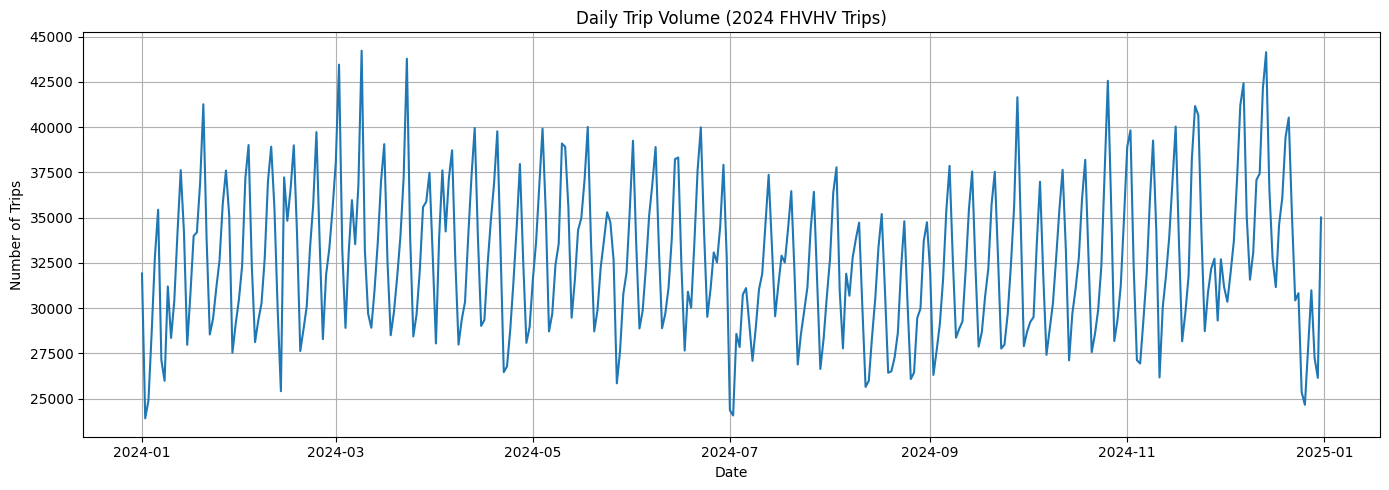

In [10]:
df['pickup_date'] = df['pickup_datetime'].dt.date

daily_trips = df.groupby('pickup_date').size()

plt.figure(figsize=(14, 5))
daily_trips.plot()
plt.title("Daily Trip Volume (2024 FHVHV Trips)")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.tight_layout()
plt.show()


 # Analysis

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from datetime import datetime


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from IPython.display import display

def analyze_fhvhv_data(parquet_path="Cleaned_FHVHV.parquet", location_lookup_path="taxi_zone_lookup.csv"):
    # === Load and prepare data ===
    df = pd.read_parquet(parquet_path)
    datetime_cols = ["pickup_datetime", "dropoff_datetime", "request_datetime", "on_scene_datetime"]
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    df.dropna(subset=datetime_cols, inplace=True)

    # Load taxi zone coordinates
    location_lookup = pd.read_csv(location_lookup_path)

    # === Descriptive Statistics ===
    print("==== Descriptive Statistics ====")
    print(df.describe())
    print("\nTrip Type Distribution:")
    print(df['fhvhv_type'].value_counts())
    print("\nTrip Distance Class Distribution:")
    print(df['trip_distance_class'].value_counts())
    print("\nTrip Category Distribution:")
    print(df['trip_category'].value_counts())

    # === Daily Trip Volume ===
    df['pickup_date'] = df['pickup_datetime'].dt.date
    daily_trips = df.groupby('pickup_date').size()
    plt.figure(figsize=(14, 5))
    daily_trips.plot()
    plt.title("Daily Trip Volume (2024)")
    plt.xlabel("Date")
    plt.ylabel("Number of Trips")
    plt.grid()
    plt.tight_layout()
    plt.show()

    # === Hourly Trip Demand ===
    plt.figure(figsize=(10,5))
    sns.countplot(data=df, x='pickup_hour', palette='viridis')
    plt.title("Hourly Trip Distribution")
    plt.xlabel("Hour of Day")
    plt.ylabel("Trip Count")
    plt.tight_layout()
    plt.show()

    # === Trip Category Pie ===
    plt.figure(figsize=(6,4))
    df['trip_category'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title("Trip Category Share (Solo vs Shared)")
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

    # === Distance Class Distribution ===
    sns.countplot(data=df, x='trip_distance_class', order=['short','medium','long'], palette='pastel')
    plt.title("Trip Distance Class Distribution")
    plt.tight_layout()
    plt.show()

    # === Fare per Mile vs Distance Class ===
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x='trip_distance_class', y='fare_per_mile')
    plt.title("Fare per Mile by Trip Distance Class")
    plt.tight_layout()
    plt.show()

    # === Congestion vs Speed ===
    sns.boxplot(data=df, x='is_congested', y='average_speed')
    plt.title("Average Speed vs Congestion")
    plt.tight_layout()
    plt.show()

    # === Pickup Heatmap in Notebook ===
    try:
        sample = df.sample(50000)
        sample = sample.merge(location_lookup[['LocationID', 'Latitude', 'Longitude']],
                              left_on='PULocationID', right_on='LocationID', how='left')
        sample.dropna(subset=['Latitude', 'Longitude'], inplace=True)

        if sample.empty:
            print("❌ No valid coordinates for pickup heatmap.")
        else:
            print(f"✅ Pickup heatmap points: {len(sample)}")
            m = folium.Map(location=[40.75, -73.97], zoom_start=11)
            heat_data = list(zip(sample['Latitude'], sample['Longitude']))
            HeatMap(heat_data, radius=8).add_to(m)
            display(m)
    except Exception as e:
        print(f"❌ Pickup heatmap error: {e}")

    # === Correlation Matrix ===
    plt.figure(figsize=(14,10))
    corr = df[['trip_miles', 'trip_time', 'average_speed', 'fare_per_mile', 'total_fare_components']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()

    # === Fare vs Speed Scatterplot ===
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df.sample(10000), x='average_speed', y='fare_per_mile', hue='trip_category', alpha=0.6)
    plt.title("Fare per Mile vs Average Speed by Trip Category")
    plt.tight_layout()
    plt.show()

    # === Hourly Pickup Heatmaps (inline) ===
    print("🕐 Generating hourly pickup heatmaps (inline)...")
    try:
        hourly_sample = df.sample(50000)
        hourly_sample = hourly_sample.merge(location_lookup[['LocationID', 'Latitude', 'Longitude']],
                                            left_on='PULocationID', right_on='LocationID', how='left')
        hourly_sample.dropna(subset=['Latitude', 'Longitude'], inplace=True)

        for hour in range(24):
            hour_df = hourly_sample[hourly_sample['pickup_hour'] == hour]
            if len(hour_df) < 50:
                continue

            heat_map = folium.Map(location=[40.75, -73.97], zoom_start=11)
            heat_data = list(zip(hour_df['Latitude'], hour_df['Longitude']))
            HeatMap(heat_data, radius=8).add_to(heat_map)

            print(f"🕑 Hour {hour:02d} — {len(hour_df)} pickups")
            display(heat_map)
    except Exception as e:
        print(f"❌ Hourly heatmap generation error: {e}")

    # === Top Pickup Zones ===
    plt.figure(figsize=(10, 5))
    top_pu = df['PULocationID'].value_counts().head(10)
    top_pu.plot(kind='bar', color='skyblue')
    plt.title("Top 10 Pickup Locations")
    plt.xlabel("Zone ID")
    plt.ylabel("Trip Count")
    plt.tight_layout()
    plt.show()


In [12]:
import geopandas as gpd

# Load shapefile
gdf = gpd.read_file("taxi_zones.shp")

# Rename to standard naming
gdf = gdf.rename(columns={"zone": "Zone", "borough": "Borough"})

# Calculate centroid coordinates
gdf["Latitude"] = gdf.geometry.centroid.y
gdf["Longitude"] = gdf.geometry.centroid.x

# Select only needed columns
zone_lookup = gdf[["LocationID", "Borough", "Zone", "Latitude", "Longitude"]]

# Save to CSV
zone_lookup.to_csv("taxi_zone_lookup.csv", index=False)
print("✅ Saved: taxi_zone_lookup.csv")


✅ Saved: taxi_zone_lookup.csv


In [14]:
import geopandas as gpd
import os

# Use your actual folder path
folder_path = r"D:\GUC\06-Capstone Project\Full Project\Taxi-FHVHV\work"
shapefile_path = os.path.join(folder_path, "taxi_zones.shp")

# Load shapefile
gdf = gpd.read_file(shapefile_path)

# Reproject to WGS84 (latitude/longitude)
gdf = gdf.to_crs(epsg=4326)

# Compute proper lat/lon
gdf["Latitude"] = gdf.centroid.y
gdf["Longitude"] = gdf.centroid.x

# Save lookup CSV
lookup = gdf[["LocationID", "borough", "zone", "Latitude", "Longitude"]]
lookup.to_csv(os.path.join(folder_path, "taxi_zone_lookup.csv"), index=False)

print("✅ Saved: taxi_zone_lookup.csv with correct lat/lon coordinates")


DataSourceError: D:\GUC\06-Capstone Project\Full Project\Taxi-FHVHV\work/taxi_zones.shp: No such file or directory

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from IPython.display import display

def analyze_fhvhv_data(parquet_path="Cleaned_FHVHV.parquet", location_lookup_path="taxi_zone_lookup.csv"):
    # === Load and prepare data ===
    df = pd.read_parquet(parquet_path)
    datetime_cols = ["pickup_datetime", "dropoff_datetime", "request_datetime", "on_scene_datetime"]
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    df.dropna(subset=datetime_cols, inplace=True)

    # Load taxi zone coordinates
    location_lookup = pd.read_csv(location_lookup_path)

    # === Descriptive Statistics ===
    print("==== Descriptive Statistics ====")
    print(df.describe())
    print("\nTrip Type Distribution:")
    print(df['fhvhv_type'].value_counts())
    print("\nTrip Distance Class Distribution:")
    print(df['trip_distance_class'].value_counts())
    print("\nTrip Category Distribution:")
    print(df['trip_category'].value_counts())

    # === Daily Trip Volume ===
    df['pickup_date'] = df['pickup_datetime'].dt.date
    daily_trips = df.groupby('pickup_date').size()
    plt.figure(figsize=(14, 5))
    daily_trips.plot()
    plt.title("Daily Trip Volume (2024)")
    plt.xlabel("Date")
    plt.ylabel("Numbe   r of Trips")
    plt.grid()
    plt.tight_layout()
    plt.show()

    # === Hourly Trip Demand ===
    plt.figure(figsize=(10,5))
    sns.countplot(data=df, x='pickup_hour', palette='viridis')
    plt.title("Hourly Trip Distribution")
    plt.xlabel("Hour of Day")
    plt.ylabel("Trip Count")
    plt.tight_layout()
    plt.show()

    # === Trip Category Pie ===
    plt.figure(figsize=(6,4))
    df['trip_category'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.title("Trip Category Share (Solo vs Shared)")
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

    # === Distance Class Distribution ===
    sns.countplot(data=df, x='trip_distance_class', order=['short','medium','long'], palette='pastel')
    plt.title("Trip Distance Class Distribution")
    plt.tight_layout()
    plt.show()

    # === Fare per Mile vs Distance Class ===
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df, x='trip_distance_class', y='fare_per_mile')
    plt.title("Fare per Mile by Trip Distance Class")
    plt.tight_layout()
    plt.show()

    # === Congestion vs Speed ===
    sns.boxplot(data=df, x='is_congested', y='average_speed')
    plt.title("Average Speed vs Congestion")
    plt.tight_layout()
    plt.show()

    # === Pickup Heatmap: All Hours Combined ===
    try:
        sample = df.sample(50000)
        sample = sample.merge(location_lookup[['LocationID', 'Latitude', 'Longitude']],
                              left_on='PULocationID', right_on='LocationID', how='left')
        sample.dropna(subset=['Latitude', 'Longitude'], inplace=True)

        print(f"✅ Pickup heatmap points: {len(sample)}")
        # Weight = frequency per location and hour
        sample['weight'] = 1
        heat_data = list(zip(sample['Latitude'], sample['Longitude'], sample['weight']))
        m = folium.Map(location=[40.75, -73.97], zoom_start=11)
        HeatMap(heat_data, radius=8).add_to(m)
        display(m)
    except Exception as e:
        print(f"❌ Pickup heatmap error: {e}")

    # === Correlation Matrix ===
    plt.figure(figsize=(14,10))
    corr = df[['trip_miles', 'trip_time', 'average_speed', 'fare_per_mile', 'total_fare_components']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()

    # === Fare vs Speed Scatterplot ===
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df.sample(10000), x='average_speed', y='fare_per_mile', hue='trip_category', alpha=0.6)
    plt.title("Fare per Mile vs Average Speed by Trip Category")
    plt.tight_layout()
    plt.show()

    # === Hourly Demand Matrix ===
    df['pickup_day'] = df['pickup_datetime'].dt.day_name()
    hourly_matrix = df.groupby(['pickup_hour', 'pickup_day']).size().unstack().fillna(0)

    # Reorder days
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    hourly_matrix = hourly_matrix[day_order]

    plt.figure(figsize=(12, 6))
    sns.heatmap(hourly_matrix, cmap='YlOrRd', linewidths=0.2, annot=False)
    plt.title("Hourly Pickup Demand by Day of Week")
    plt.xlabel("Day of Week")
    plt.ylabel("Hour of Day")
    plt.tight_layout()
    plt.show()

    # === Top Pickup Zones ===
    # plt.figure(figsize=(10, 5))
    # top_pu = df['PULocationID'].value_counts().head(10)
    # top_pu.plot(kind='bar', color='skyblue')
    # plt.title("Top 10 Pickup Locations")
    # plt.xlabel("Zone ID")
    # plt.ylabel("Trip Count")
    # plt.tight_layout()
    # plt.show()

        # === Top Pickup Zones by Name ===
    top_pu = df['PULocationID'].value_counts().head(10).reset_index()
    top_pu.columns = ['PULocationID', 'TripCount']

    # Merge to get zone names
    zone_names = location_lookup[['LocationID', 'zone']]
    top_pu = top_pu.merge(zone_names, left_on='PULocationID', right_on='LocationID', how='left')

    # Plot using zone names
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_pu, x='zone', y='TripCount', palette='Blues_d')
    plt.title("Top 10 Pickup Locations by Zone")
    plt.xlabel("Zone Name")
    plt.ylabel("Trip Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



==== Descriptive Statistics ====
                    request_datetime              on_scene_datetime  \
count                       11964888                       11964888   
mean   2024-07-01 20:52:39.917016576  2024-07-01 20:55:56.375155968   
min              2023-12-31 23:29:55            2023-12-31 23:32:49   
25%    2024-03-31 09:26:35.249999872  2024-03-31 09:28:51.249999872   
50%       2024-06-29 10:15:09.500000     2024-06-29 10:17:49.500000   
75%              2024-10-03 06:58:40  2024-10-03 07:01:31.750000128   
max              2024-12-31 23:58:26            2024-12-31 23:59:23   
std                              NaN                            NaN   

                     pickup_datetime               dropoff_datetime  \
count                       11964888                       11964888   
mean   2024-07-01 20:57:12.631818752  2024-07-01 21:17:20.531270656   
min              2024-01-01 00:00:02            2024-01-01 00:05:21   
25%    2024-03-31 09:30:10.249999872  2024-

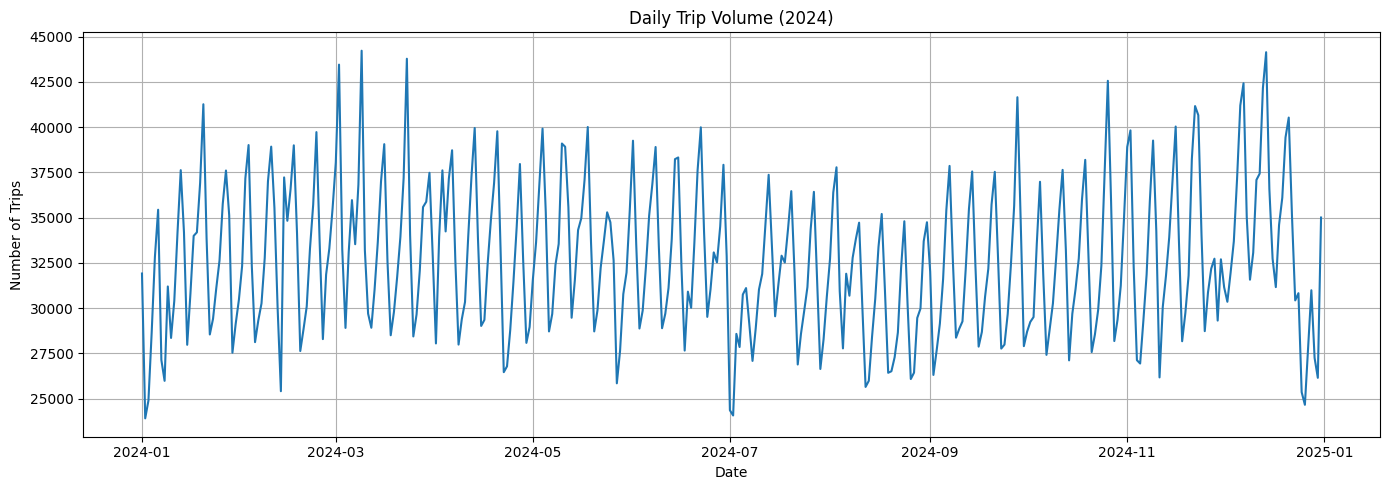

C:\Users\osama\AppData\Local\Temp\ipykernel_12236\4184144332.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='pickup_hour', palette='viridis')


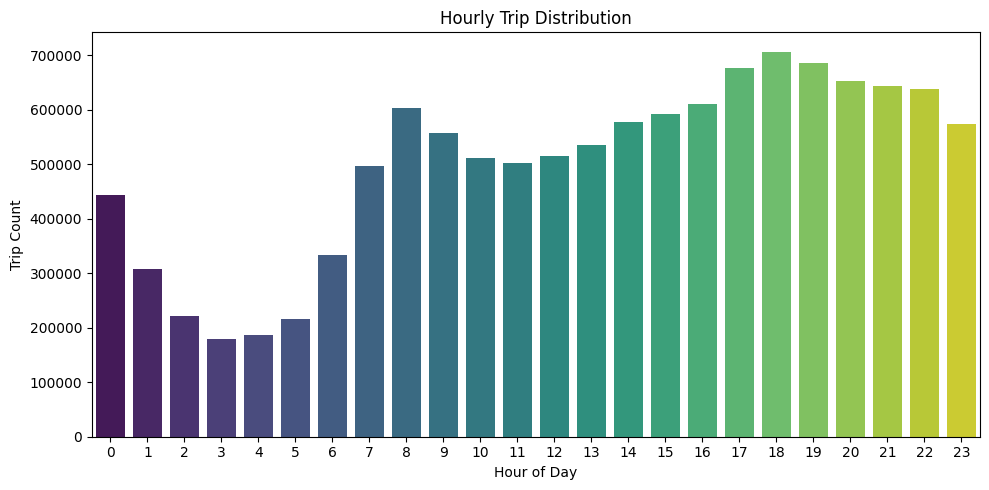

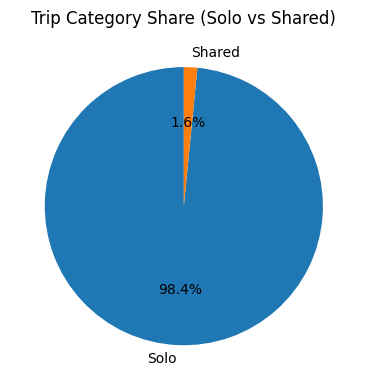

C:\Users\osama\AppData\Local\Temp\ipykernel_12236\4184144332.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='trip_distance_class', order=['short','medium','long'], palette='pastel')


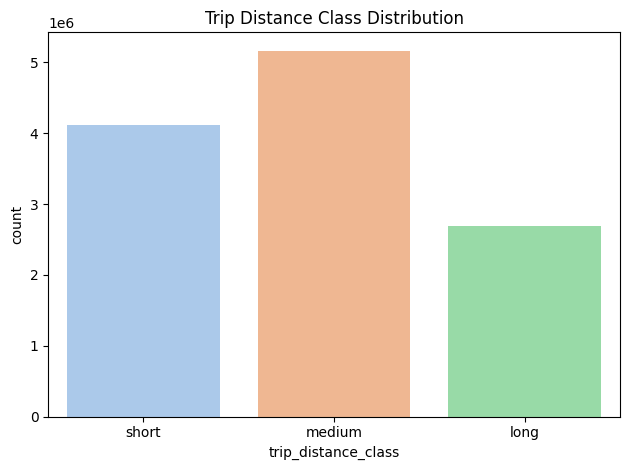

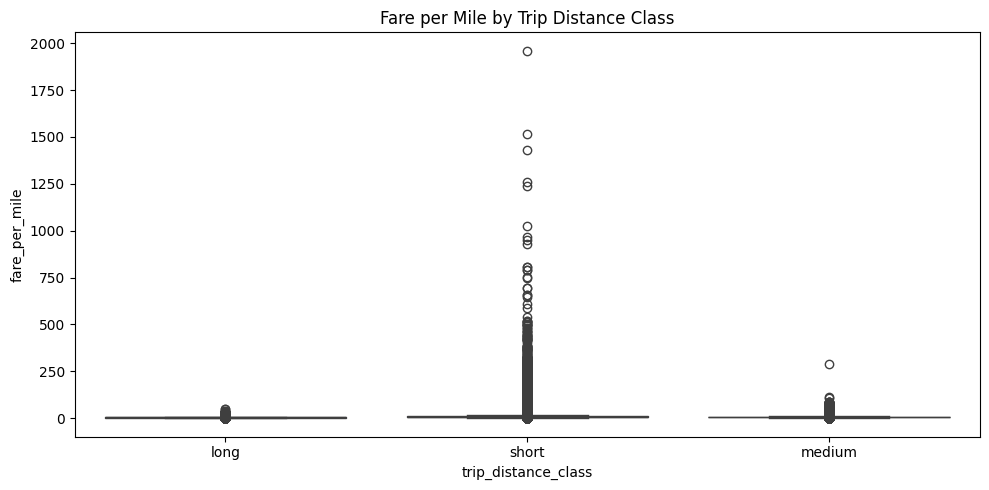

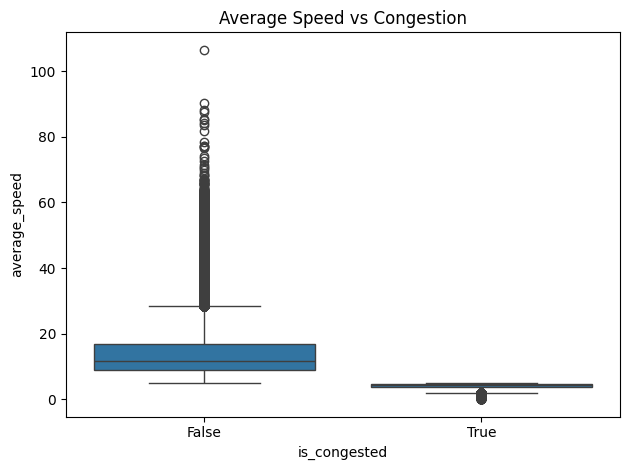

✅ Pickup heatmap points: 50117


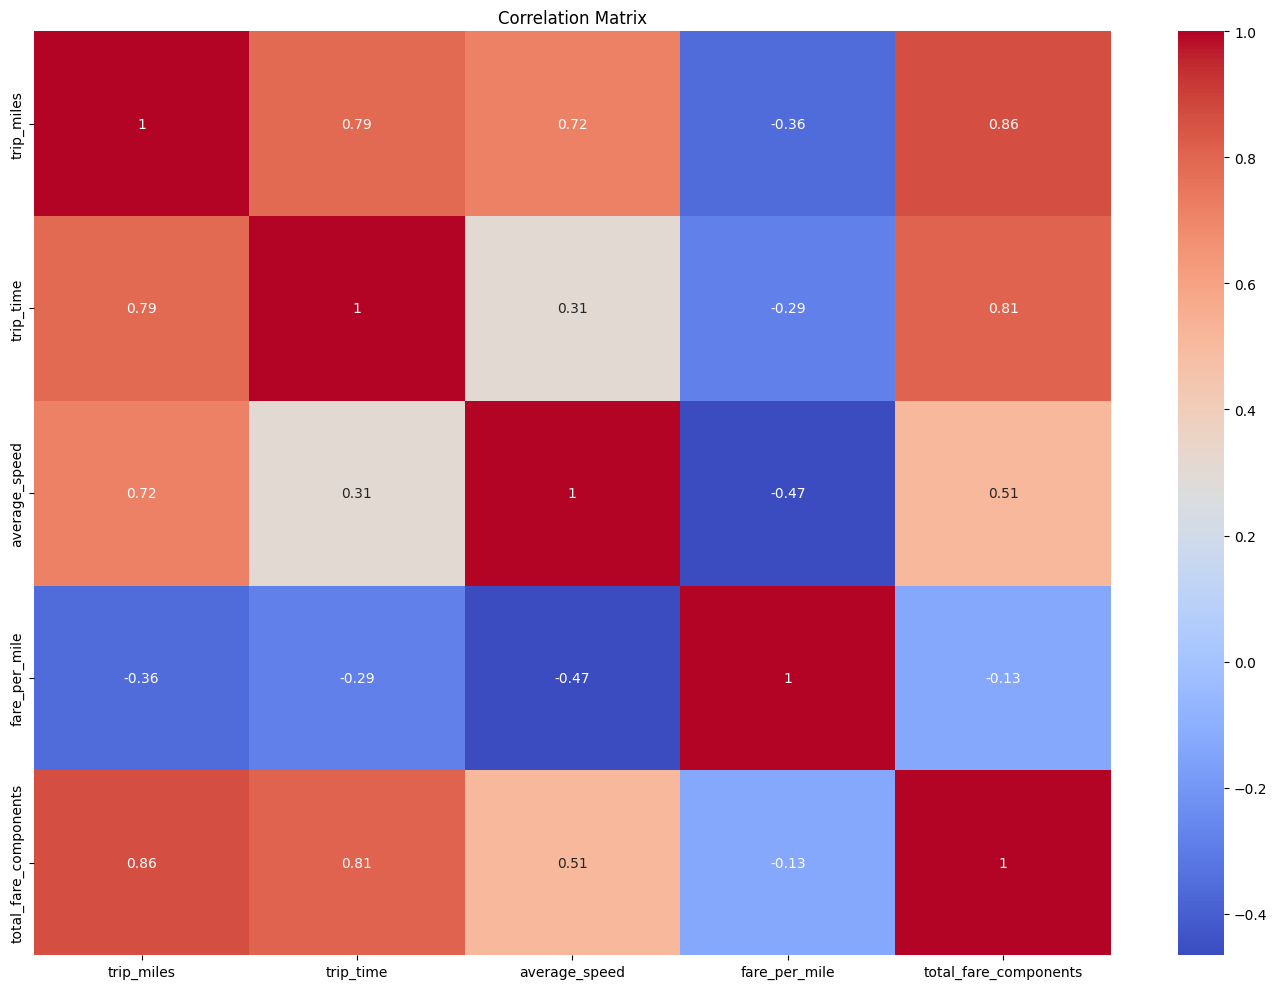

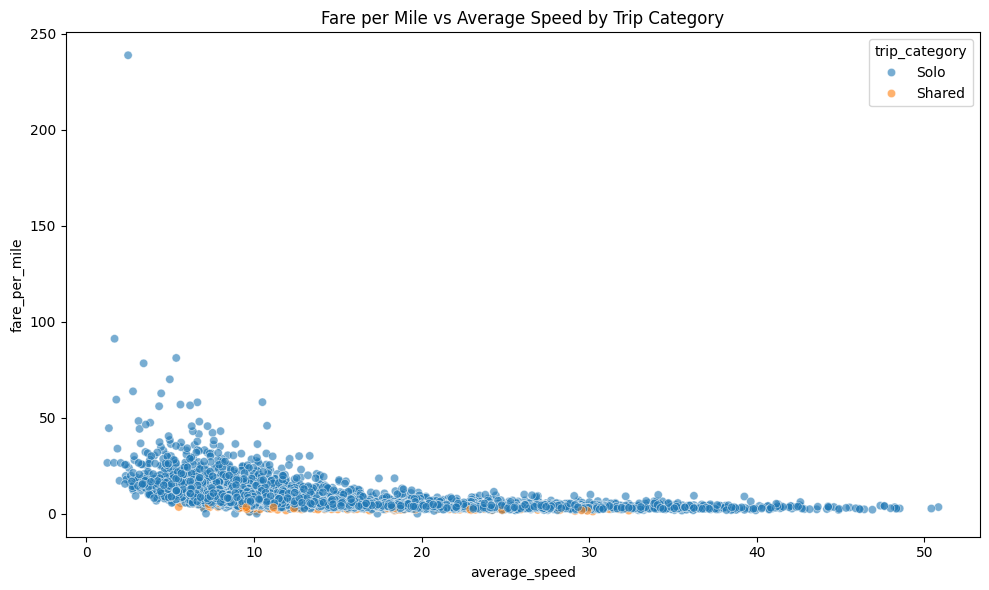

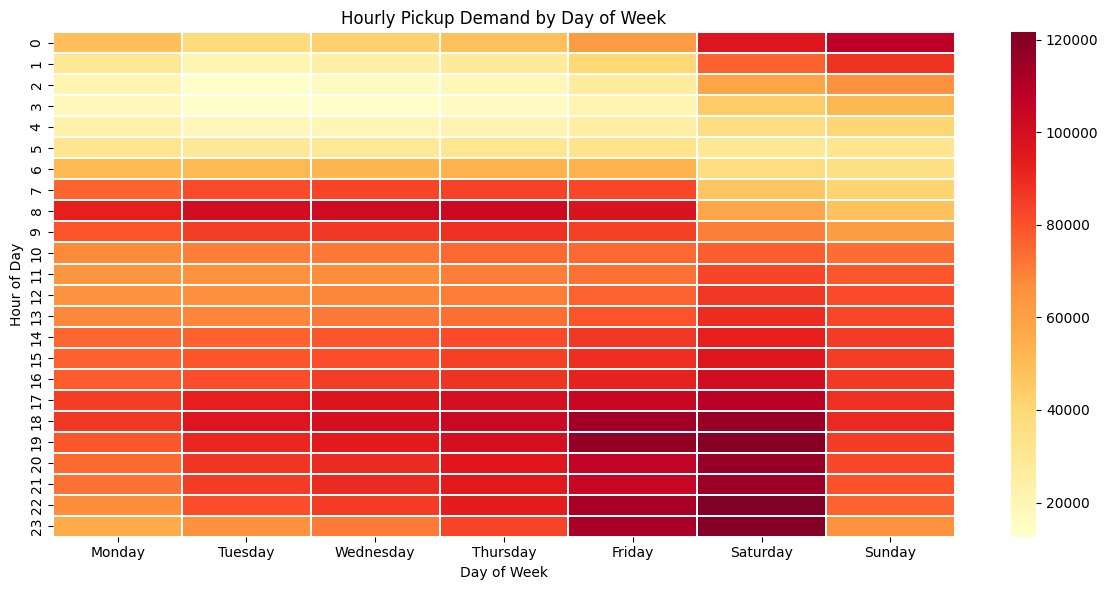

C:\Users\osama\AppData\Local\Temp\ipykernel_12236\4184144332.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pu, x='zone', y='TripCount', palette='Blues_d')


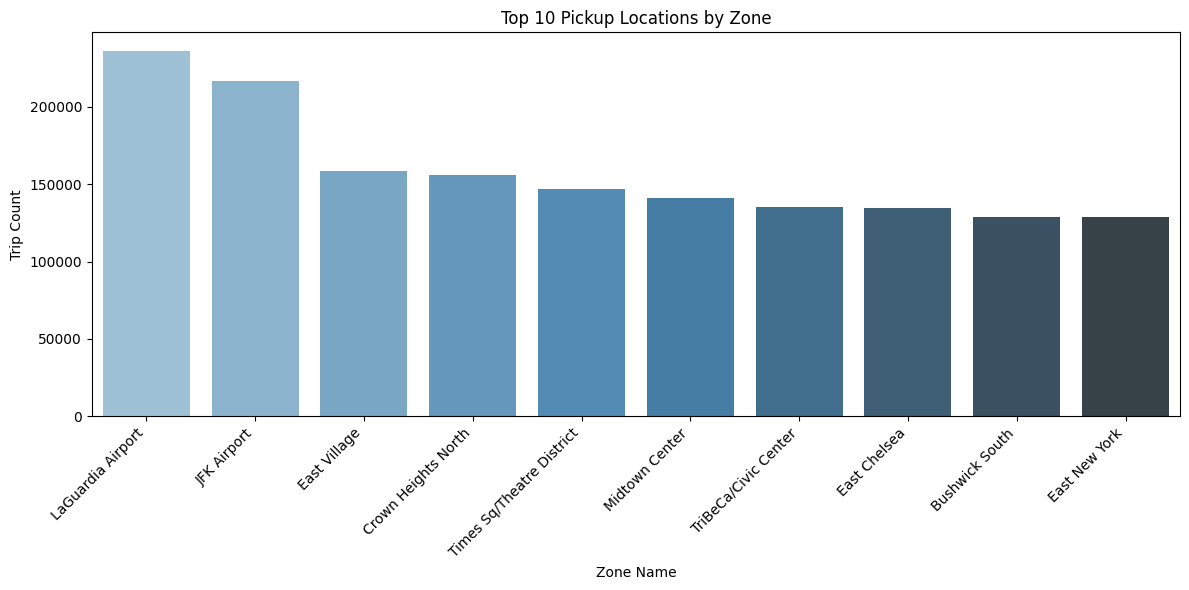

In [41]:
analyze_fhvhv_data("Cleaned_FHVHV.parquet", "taxi_zone_lookup.csv")


# KPI's

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from IPython.display import display, HTML

def analyze_fhvhv_data(parquet_path="Cleaned_FHVHV.parquet", location_lookup_path="taxi_zone_lookup.csv"):
    # === Load data ===
    df = pd.read_parquet(parquet_path)
    datetime_cols = ["pickup_datetime", "dropoff_datetime", "request_datetime", "on_scene_datetime"]
    for col in datetime_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    df.dropna(subset=datetime_cols, inplace=True)

    # === Load taxi zone info ===
    zone_lookup = pd.read_csv(location_lookup_path)
    if "borough" not in zone_lookup.columns:
        # Try fallback capitalization if needed
        zone_lookup.columns = [c.lower() for c in zone_lookup.columns]

    # === Add derived features ===
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_date'] = df['pickup_datetime'].dt.date

    # === KPIs ===
    print("\n📊 === Key Performance Indicators (KPIs) ===")
    print(f"🚕 Total Trips: {len(df):,}")
    print(f"🧾 Avg Fare per Mile: ${df['fare_per_mile'].mean():.2f}")
    print(f"🕒 Avg Trip Duration: {df['trip_time'].mean():.1f} minutes")
    print(f"🛣️ Longest Trip Distance: {df['trip_miles'].max():.2f} miles")
    print(f"⏱️ Longest Trip Duration: {df['trip_time'].max():.1f} minutes")
    print(f"💰 Highest Fare Amount: ${df['total_fare_components'].max():,.2f}")
    print(f"🧮 Median Fare per Mile: ${df['fare_per_mile'].median():.2f}")
    print(f"🤝 % Shared Trips: {(df['trip_category'].value_counts(normalize=True).get('shared', 0)*100):.1f}%")
    print(f"📅 Total Active Days: {df['pickup_date'].nunique()} days")

    # Borough-level Trip Counts
    df_boro = df.merge(zone_lookup[['locationid', 'borough']], left_on='PULocationID', right_on='locationid', how='left')
    borough_counts = df_boro['borough'].value_counts()
    print("\n🌇 Trips per Borough:")
    print(borough_counts)

    # Borough with Highest Avg Fare
    boro_fare = df_boro.groupby("borough")["fare_per_mile"].mean().sort_values(ascending=False)
    print(f"\n💸 Borough with Highest Avg Fare per Mile: {boro_fare.idxmax()} (${boro_fare.max():.2f})")

    # === Top Pickup Zones (by name not ID) ===
    top_zones = df['PULocationID'].value_counts().head(10).rename_axis("LocationID").reset_index(name="TripCount")
    top_zones = top_zones.merge(zone_lookup[['locationid', 'zone']], left_on='LocationID', right_on='locationid', how='left')
    
    plt.figure(figsize=(10,5))
    sns.barplot(data=top_zones, x='zone', y='TripCount', palette='Blues_d')
    plt.title("Top 10 Pickup Zones (by Zone Name)")
    plt.ylabel("Trip Count")
    plt.xlabel("Zone")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # === Trip Distribution by Hour ===
    plt.figure(figsize=(10,5))
    sns.countplot(data=df, x='pickup_hour', palette='viridis')
    plt.title("Hourly Trip Demand")
    plt.xlabel("Hour of Day")
    plt.ylabel("Trip Count")
    plt.tight_layout()
    plt.show()

    # === Pickup Heatmap ===
    sample = df.sample(50000)
    sample = sample.merge(zone_lookup[['locationid', 'Latitude', 'Longitude']], left_on='PULocationID', right_on='locationid', how='left')
    sample.dropna(subset=['Latitude', 'Longitude'], inplace=True)

    if not sample.empty:
        m = folium.Map(location=[40.75, -73.97], zoom_start=11)
        heat_data = list(zip(sample['Latitude'], sample['Longitude']))
        HeatMap(heat_data, radius=8).add_to(m)
        display(m)

    # === Hourly Demand Heatmap (Matrix) ===
    pivot_hourly = df.pivot_table(index='pickup_hour', columns='trip_category', aggfunc='size', fill_value=0)
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot_hourly, annot=True, cmap='YlGnBu', fmt='d')
    plt.title("Trip Category Demand by Hour")
    plt.xlabel("Trip Category")
    plt.ylabel("Hour of Day")
    plt.tight_layout()
    plt.show()

    # === Correlation Heatmap ===
    plt.figure(figsize=(10,8))
    corr = df[['trip_miles', 'trip_time', 'average_speed', 'fare_per_mile', 'total_fare_components']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()



📊 === Key Performance Indicators (KPIs) ===
🚕 Total Trips: 11,964,888
🧾 Avg Fare per Mile: $7.39
🕒 Avg Trip Duration: 1207.9 minutes
🛣️ Longest Trip Distance: 469.41 miles
⏱️ Longest Trip Duration: 42478.0 minutes
💰 Highest Fare Amount: $1,499.85
🧮 Median Fare per Mile: $6.28
🤝 % Shared Trips: 0.0%
📅 Total Active Days: 366 days

🌇 Trips per Borough:
borough
Manhattan        4651920
Brooklyn         3154251
Queens           2537850
Bronx            1477183
Staten Island     175864
EWR                    1
Name: count, dtype: int64

💸 Borough with Highest Avg Fare per Mile: EWR ($1431.00)


/tmp/ipykernel_191248/2986971976.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_zones, x='zone', y='TripCount', palette='Blues_d')


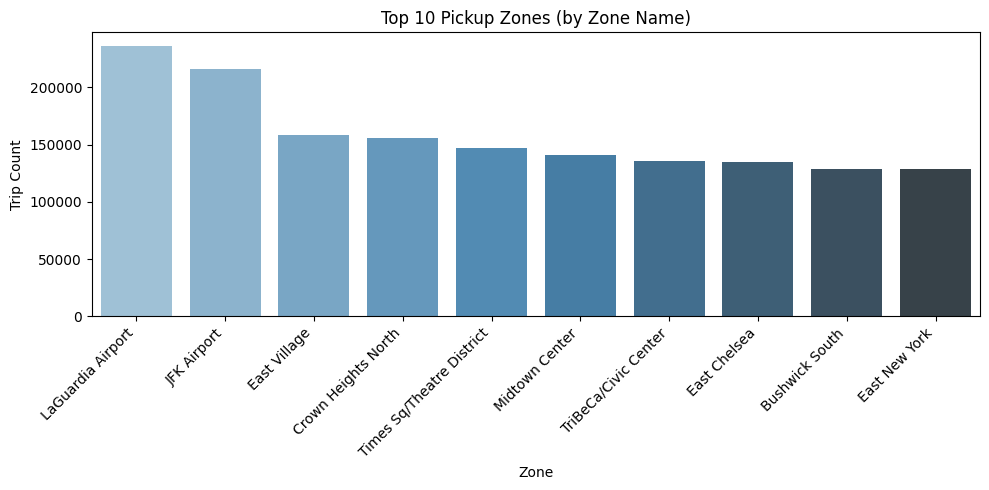

/tmp/ipykernel_191248/2986971976.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='pickup_hour', palette='viridis')


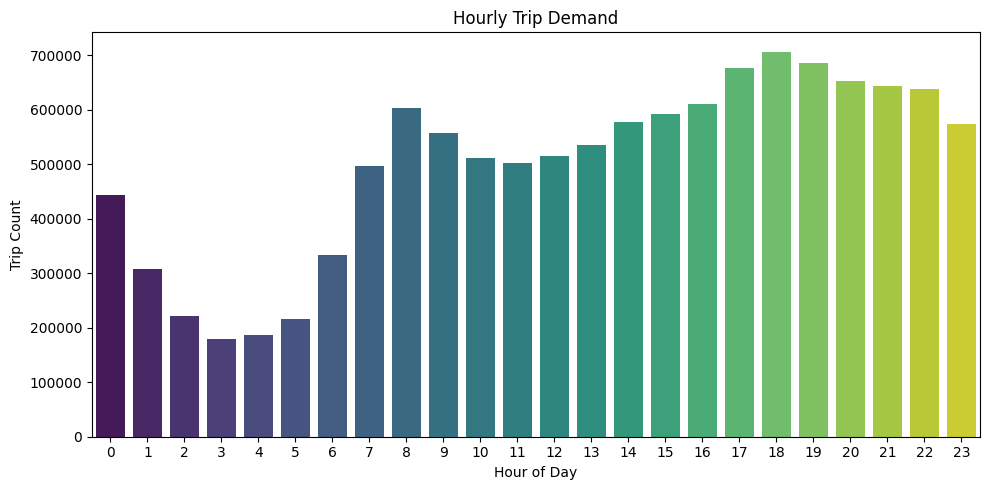

KeyError: "['Latitude', 'Longitude'] not in index"

In [17]:
analyze_fhvhv_data()
